### Generate CSV for Telenav API traffic sign detection
CSV for deep learning of telenav images


In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL
from PIL import Image
import cv2
import numpy as np
from glob import glob

In [17]:
CLASS_NAME_DICT  =  dict(
              ((40,  'TURN_RESTRICTION_RIGHT_US'),
               (41,  'TURN_RESTRICTION_U_TURN_US'),
               (43,  'STOP_US'),
               (123, 'TRAFFIC_LIGHTS_SIGN'),
               (39,  'TURN_RESTRICTION_LEFT_US'),
               (16,  'SPEED_LIMIT_5_US'), 
               (17,  'SPEED_LIMIT_10_US'), 
               (18,  'SPEED_LIMIT_15_US'), 
               (19,  'SPEED_LIMIT_20_US'), 
               (20,  'SPEED_LIMIT_25_US'),
               (21,  'SPEED_LIMIT_30_US'), 
               (22,  'SPEED_LIMIT_35_US'), 
               (23,  'SPEED_LIMIT_40_US'), 
               (24,  'SPEED_LIMIT_45_US'), 
               (25,  'SPEED_LIMIT_50_US'),
               (26,  'SPEED_LIMIT_55_US'), 
               (27,  'SPEED_LIMIT_60_US'),
               (28,  'SPEED_LIMIT_65_US'), 
               (29,  'SPEED_LIMIT_70_US'),
                (30,  'SPEED_LIMIT_75_US'),
               (31,  'SPEED_LIMIT_80_US'),
               (42,  'TURN_RESTRICTION_U_TURN_LEFT_US'),
               (69,  'YIELD_US')))

def read_df(metadata):

    images = metadata.images    
    data_df = pd.DataFrame({"img_proto": images})
    data_df.loc[:,"img_name"] = data_df.loc[:,"img_proto"].apply(lambda image: image.metadata.image_path)
    data_df.loc[:, "rois"] = data_df.loc[:,"img_proto"].apply(lambda image:image.rois)
    data_df.loc[:, "nr_rois"] = data_df.loc[:,"rois"].apply(len)
    data_df = data_df.drop(["img_proto"],axis=1)
        
    return data_df

def explode_rois(data_df):
    
    rois_df_cols = list(data_df.columns)
    rois_df_cols.append("roi")

    rows = []
    _ = data_df.apply(lambda row: [rows.append(row.tolist() + [nn]) for nn in row.rois], axis=1)

    rois_df = pd.DataFrame(rows, columns=rois_df_cols)
    
    rois_df.loc[:,"roi_type"] = rois_df.loc[:,"roi"].apply(lambda roi: CLASS_NAME_DICT[roi.type])
    
    rois_df = rois_df.drop(["rois","nr_rois"],axis=1)
    
    return rois_df

def plot_data_df(data_df,nr_images_to_plot):
    for _,row in data_df.iloc[:nr_images_to_plot].iterrows():

        img_path = os.path.join(images_folder,row["img_name"])
        img=PIL.Image.open(img_path)
        print(img.size)
        img = np.asarray(img)
        

        gt_image_rois = row["rois"]

        for roi in gt_image_rois:
            tl_col = roi.rect.tl.col
            tl_row = roi.rect.tl.row
            br_col = roi.rect.br.col
            br_row = roi.rect.br.row

            img = cv2.rectangle(img, (tl_col,tl_row), (br_col, br_row), (0,255,0), 10)
            img = cv2.putText(img, CLASS_NAME_DICT[roi.type], (tl_col-10, tl_row-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)
       
        plt.figure(figsize=(14,14))
        plt.imshow(img)
        plt.show()
        
        
def plot_roi_df(roi_df,nr_rois_to_plot):
    for _,row in roi_df.iloc[:nr_rois_to_plot].iterrows():

        img_path = os.path.join(images_folder,row["img_name"])
        img = np.asarray(PIL.Image.open(img_path))

        roi = row["roi"]

        tl_col = roi.rect.tl.col
        tl_row = roi.rect.tl.row
        br_col = roi.rect.br.col
        br_row = roi.rect.br.row

        img = cv2.rectangle(img, (tl_col,tl_row), (br_col, br_row), (0,255,0), 10)
        img = cv2.putText(img, CLASS_NAME_DICT[roi.type], (tl_col-10, tl_row-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)


        plt.figure(figsize=(14,14))
        plt.imshow(img)
        plt.show()
        

# 1.Setup Environment

Here we will download the zip containing the dataset and then perform some basic manipulations on the images and on the ROIs (region of interest). Below, we will refer to all the labeled ground truth as ROIs

This notebook will only work on a Unix-based environment

## 1.3 Import necessary proto files

When reading the protobuf files, the path to the generated protobuf definitions located in the **protobuf** folder needs to be in your python path.

You can also check the structure of the protobuf files in the **protobuf** folder

In [3]:
#./telenav_ai_dataset_sample/protobuf
sys.path.append("/workspace/datasets/telenav_ai_dataset/protobuf/")
import proto_api as proto_api

## 1.4 Set Paths

In [4]:
images_folder = "/workspace/datasets/telenav_ai_dataset/train_data/"
rois_path = os.path.join(images_folder,"rois.bin")
images_paths = glob(images_folder + "*[jpg,jpeg]")

# 2 Read Data

In [5]:
imageset_proto = proto_api.read_metadata(rois_path)
data_df = read_df(imageset_proto)
data_df.head()

,img_name,rois,nr_rois
0,10676_19a5b_579a6ef320f18.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,5
1,50486_1d629_58b79c6830a01.jpg,[],0
2,493719_5129c_6.jpg,[type: SPEED_LIMIT_30_US\nrect {\n tl {\n ...,1
3,527601_d3dc2_25.jpg,[type: SPEED_LIMIT_65_US\nrect {\n tl {\n ...,1
4,427178_3deb8_592f99e0564f2.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,10


## 2.1 Basic Stats

In [6]:
print("Number of images: {}".format(len(data_df)))
print("Number of rois: {}".format(data_df["nr_rois"].sum()))
print("Count by number of rois in image: ")
data_df["nr_rois"].value_counts()

Number of images: 46481
Number of rois: 56015
Count by number of rois in image: 


1     23490
0     12245
2      4773
3      2988
4      1718
5       769
6       312
7       115
8        39
9        18
10        9
11        3
12        2
Name: nr_rois, dtype: int64

In [7]:
rois_df = explode_rois(data_df)
print("Number of ROIs by type: ")
rois_df["roi_type"].value_counts()


Number of ROIs by type: 


TRAFFIC_LIGHTS_SIGN                20541
TURN_RESTRICTION_LEFT_US            6994
SPEED_LIMIT_40_US                   3034
SPEED_LIMIT_35_US                   2992
SPEED_LIMIT_45_US                   2733
STOP_US                             2638
SPEED_LIMIT_30_US                   2631
SPEED_LIMIT_55_US                   2446
SPEED_LIMIT_25_US                   2368
TURN_RESTRICTION_RIGHT_US           2193
TURN_RESTRICTION_U_TURN_US          1501
SPEED_LIMIT_70_US                   1366
YIELD_US                            1227
SPEED_LIMIT_65_US                    960
SPEED_LIMIT_50_US                    904
SPEED_LIMIT_60_US                    783
SPEED_LIMIT_75_US                    260
SPEED_LIMIT_80_US                    221
TURN_RESTRICTION_U_TURN_LEFT_US       75
SPEED_LIMIT_20_US                     55
SPEED_LIMIT_15_US                     41
SPEED_LIMIT_10_US                     31
SPEED_LIMIT_5_US                      21
Name: roi_type, dtype: int64

## 2.2 Visualize Images with all ROIs

In [8]:
non_empty_df = data_df[data_df["nr_rois"] != 0]

(2592, 1944)


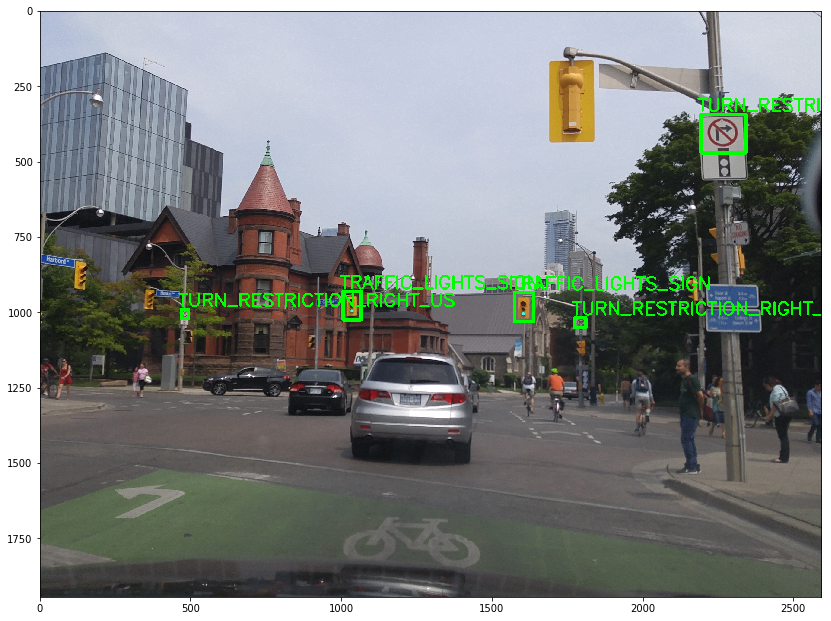

(2592, 1936)


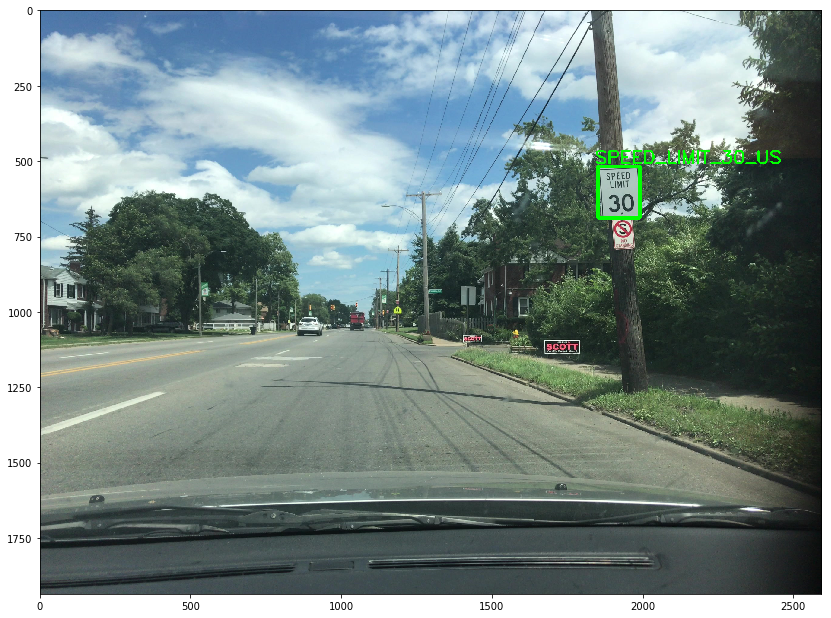

In [18]:
plot_data_df(non_empty_df,nr_images_to_plot = 2)

## 2.3 Visualize ROIs of specific type

Note that this visualization is a bit different from the one above, in the sense that each ROI is plotted in a separate figure, even if they are part of the same image. In the visualization above, we plotted an image with all of its ROIs in a single figure

In [ ]:
specific_type_rois_df = rois_df[rois_df["roi_type"] == "YIELD_US"]
plot_roi_df(specific_type_rois_df,nr_rois_to_plot = 4)

### For my model

In [ ]:
x_left=[]
x_right=[]
y_left=[]
y_right=[]
for index,row in rois_df.iterrows():
    roi = row["roi"]
    x_left.append(roi.rect.tl.col)
    y_left.append(roi.rect.tl.row)
    x_right.append(roi.rect.br.col)
    y_right.append(roi.rect.br.row)

rois_df['x_left']=pd.Series(x_left).values
rois_df['x_right']=pd.Series(x_right).values
rois_df['y_left']=pd.Series(y_left).values
rois_df['y_right']=pd.Series(y_right).values
    

In [ ]:
rois_df.rename(index=str, columns={'roi_type':'sign'},inplace=True)
rois_df['bbox']=rois_df['y_left'].map(str)+' '+rois_df['x_left'].map(str)+' '+rois_df['y_right'].map(str)+' '+rois_df['x_right'].map(str)
rois_df.shape

In [ ]:
min_width=70
min_height=70
rois_df['width']=rois_df.x_right - rois_df.x_left
rois_df['height']=rois_df.y_right - rois_df.y_left
rois_df=rois_df[(rois_df.width>min_width) & (rois_df.height>min_height)]
rois_df.sort_values(by=['width'], inplace=True)
print(rois_df.shape)
rois_df.head()

#### Extract only those signs which have atleast 900 occurances
Also note that I use 85% for traning and rest for validation hence limited to 900

In [ ]:
min_count=900
signs_count = pd.DataFrame(rois_df.sign.value_counts().reset_index())
signs_count=signs_count[signs_count.sign>=min_count]
signs_count.columns=['sign','counts']
rois_df=rois_df[rois_df['sign'].isin(list(signs_count.sign))]
rois_df.head()

In [ ]:
PATH='/workspace/datasets/telenav_ai_dataset/'
rois_df[['img_name','sign']].to_csv(f'{PATH}telenav_sign_labels.csv',sep=",",index=False)
rois_df[['img_name','bbox']].to_csv(f'{PATH}telenav_sign_bbox.csv',sep=",",index=False)

In [ ]:
def draw_image(image_name):
    fig,ax = plt.subplots(figsize=(14,8))
    im = np.array(Image.open(f'{PATH}train_data/{image_name}.jpg'), dtype=np.uint8)
    ax.imshow(im)
    df_image=rois_df[rois_df.img_name==(image_name+'.jpg')]
    n_rows=df_image.shape[0]
    for i in range(0,n_rows):
        x=df_image.x_left.values[i]
        y=df_image.y_left.values[i]
        width=df_image.x_right.values[i]-df_image.x_left.values[i]+1
        height=df_image.y_right.values[i]-df_image.y_left.values[i]+1
        sign=df_image.sign.values[i]
        rect = patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(x,y,s=sign,fontsize=14,color='red')
    

In [ ]:
draw_image('25327_987eb_580554719bfe0')